In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import norm
import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score

import os
print(os.listdir("../AI A4"))

# Any results you write to the current directory are saved as output.

['.idea', '.ipynb_checkpoints', 'SVM-HOG.ipynb', 'SVM_with_HOG.py', 'test.csv', 'train.csv', 'Untitled.ipynb', 'Untitled1.ipynb', 'venv', '__pycache__']


In [2]:
#import data and define the classes
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
class_names = ['0','1','2','3','4','5','6','7','8','9']

#print out training data
print(train_data.shape)
print(train_data.head())

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0      

In [3]:
train_x = train_data.iloc[:,1:].values.astype('int32') # all pixel values
train_y = train_data.iloc[:,0].values.astype('int32') # only labels i.e targets digits

test_x = test_data.iloc[:,].values.astype('int32') # all pixel values
#print(train_y)
#reshape the features to be 28x28
train_x = train_x.reshape(train_x.shape[:1] + (28, 28, 1))

test_x = test_x.reshape(test_x.shape[:1] + (28, 28, 1))

#change the labels to be one-hot encoded
#train_y = keras.utils.to_categorical(train_y,num_classes=10).astype('int32')

# #normalize pixel values using minmax (values between 0 and 1 inclusive)
train_x = train_x / 255
test_x = test_x / 255

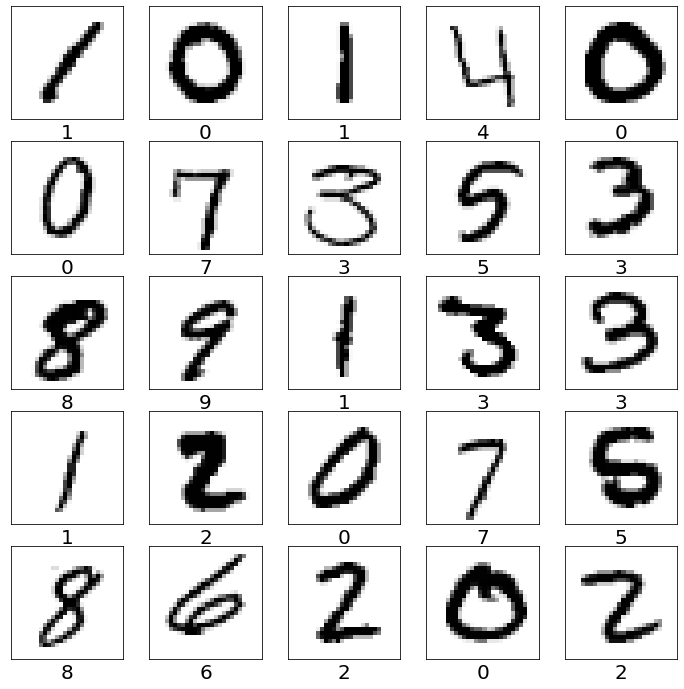

In [4]:
#plot a first 25 of features and labels to check data
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[i]],fontsize = 20)
plt.show()

In [5]:
# Deskew images ... 
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-3:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

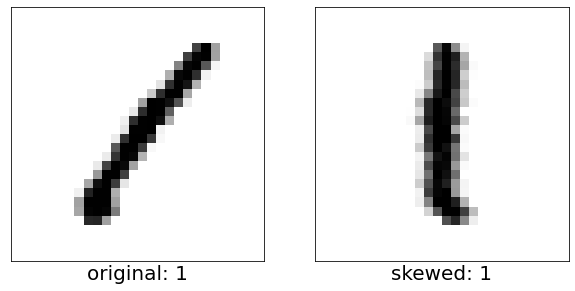

In [6]:
train_deskewed = list(map(deskew, train_x))

showInd = 0

class_name = class_names[train_y[showInd]];

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(train_x[showInd].reshape(28,28), cmap=plt.cm.binary)
plt.xlabel('original: ' + class_name,fontsize=20)

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(train_deskewed[showInd], cmap=plt.cm.binary)
plt.xlabel('skewed: ' + class_name,fontsize=20)

plt.show()

In [7]:
# HoG feature descriptor
def HOG(imgs):
    hog = cv2.HOGDescriptor((28,28),(8,8),(4,4),(8,8),9,1,-1,0,0.1,1,32, True)
    hog_descriptors = []
    for img in imgs:
        cv_img = np.around(img*255).astype('uint8')
        hog_descriptors.append(hog.compute(cv_img))

    hog_descriptors = np.squeeze(hog_descriptors)
    return hog_descriptors

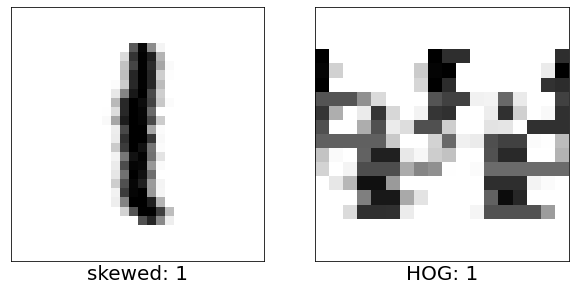

In [8]:
train_hog = HOG(train_deskewed)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(train_deskewed[showInd].reshape(28,28), cmap=plt.cm.binary)
plt.xlabel('skewed: ' + class_name,fontsize=20)

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(train_hog[showInd].reshape(18,18), cmap=plt.cm.binary)
plt.xlabel('HOG: ' + class_name,fontsize=20)

plt.show()

In [9]:
#SVM
class StatModel(object):
    def load(self, fn):
        self.model.load(fn)
    def save(self, fn):
        self.model.save(fn)

class SVM(StatModel):
    def __init__(self, C = 12.5, gamma = 0.5):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        print("The value of Gamma: %.2f "%gamma)
        self.model.setC(C)
        print("The value of C: %.2f"%C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):

        return self.model.predict(samples)[1].ravel()

print(train_y)
model = SVM()

start_time = datetime.datetime.now()     #放在程序开始处
print('train Begin')
model.train(train_hog, train_y)

end_time = datetime.datetime.now()      #放在程序结尾处
interval = (end_time-start_time).seconds    #以秒的形式
minutes = interval/60  #转换成分钟
seconds = interval%60
print ('train Done: ', int(minutes),':',seconds)

[1 0 1 ... 7 6 9]
The value of Gamma: 0.50 
The value of C: 12.50
train Begin
train Done:  3 : 29


In [10]:
# Evaluation cross_validation
clf = svm.SVC(kernel='linear', C=8)
scores = cross_val_score(clf, train_hog, train_y, cv=5)
print(scores)

# train_result = model.predict(train_hog)

# err = (train_y != train_result).mean()
# print('Accuracy: %.2f %%' % ((1 - err)*100))

[0.98690476 0.98761905 0.98690476 0.98761905 0.98690476]


In [11]:
train_result = model.predict(train_hog)

err = (train_y != train_result).mean()
print('Accuracy: %.2f %%' % ((1 - err)*100))

Accuracy: 100.00 %


In [12]:
#prediction

start_time = datetime.datetime.now()     #放在程序开始处
print('train Begin')

clf.fit(train_hog, train_y)

end_time = datetime.datetime.now()      #放在程序结尾处
interval = (end_time-start_time).seconds    #以秒的形式
minutes = interval/60  #转换成分钟
seconds = interval%60
print ('train Done: ', int(minutes),':',seconds)


test_deskewed = list(map(deskew, test_x))
test_hog = HOG(test_deskewed)

results = clf.predict(test_hog)
results = list(map(int, results))

#print(results)

train Begin
train Done:  0 : 24


In [13]:
length = len(results)
submission = pd.concat([pd.Series(range(1,length+1),name = "ImageId"),pd.Series(results,name="Label")],axis = 1)

submission.to_csv("submissionSVMHOGFinal.csv",index=False)

In [14]:
# Evaluation cross_validation
clf = svm.SVC(kernel='rbf', C=8)
scores = cross_val_score(clf, train_hog, train_y, cv=5)
print(scores)

[0.99142857 0.9925     0.99107143 0.99119048 0.99190476]


In [15]:
train_result = model.predict(train_hog)

err = (train_y != train_result).mean()
print('Accuracy: %.2f %%' % ((1 - err)*100))

Accuracy: 100.00 %


In [16]:
#prediction

start_time = datetime.datetime.now()     #放在程序开始处
print('train Begin')

clf.fit(train_hog, train_y)

end_time = datetime.datetime.now()      #放在程序结尾处
interval = (end_time-start_time).seconds    #以秒的形式
minutes = interval/60  #转换成分钟
seconds = interval%60
print ('train Done: ', int(minutes),':',seconds)


test_deskewed = list(map(deskew, test_x))
test_hog = HOG(test_deskewed)

results = clf.predict(test_hog)
results = list(map(int, results))

#print(results)

train Begin
train Done:  0 : 42


In [17]:
length = len(results)
submission = pd.concat([pd.Series(range(1,length+1),name = "ImageId"),pd.Series(results,name="Label")],axis = 1)

submission.to_csv("submissionSVMHOGFinalwithRBF.csv",index=False)